In [1]:
# # 하고자 하는 것
# 1. shrinkage parameter theta= 0.75로 설정해서
# 2. corr이 아닌 (1-theta)corr + theta * I를 MVO에 적용

# # 원하는 결과
# - EPO를 MVO에 넣었을 때 최적 가중치 ; 이걸 EPO weight로 재설정할 것

In [1]:
!pip install cvxpy
!pip install tqdm
!pip install yfinance

In [4]:
pip install pypfot

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement pypfot (from versions: none)
ERROR: No matching distribution found for pypfot


In [2]:
import numpy as np
import cvxpy as cp
import cplex
from tqdm import tqdm

# from pypfopt.efficient_frontier import EfficientFrontier
# from pypfopt import risk_models
# from pypfopt import expected_returns

import matplotlib.pyplot as plt
import pandas as pd
import pandas_datareader.data as pdr
import yfinance as yf

from dateutil.relativedelta import relativedelta
from datetime import datetime

In [3]:
mkt = pd.read_csv('../new_market.csv')
mkt['pricingDate'] = pd.to_datetime(mkt['pricingDate'])
mkt.set_index('pricingDate', inplace = True)
mkt

,A,AAL,AAPL,ABBV,ABT,ACGL,ACN,ADBE,ADI,ADM,...,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
pricingDate,,,,,,,,,,,,,,,,,,,,,
2018-05-01,66.24,43.36,42.2750,102.07,58.82,26.876666,151.92,224.08,88.86,45.03,...,191.85,46.65,76.95,50.64,70.37,86.64,116.95,136.78,55.05,83.40
2018-05-02,65.91,42.24,44.1425,100.37,57.85,26.310000,150.71,221.10,88.30,44.43,...,191.03,46.54,76.80,50.59,68.88,80.20,117.46,133.12,55.19,79.90
2018-05-03,66.34,42.11,44.2225,100.28,57.93,25.983333,151.73,226.05,87.91,43.60,...,191.62,46.48,76.54,49.24,69.63,82.67,115.18,133.54,54.45,80.38
2018-05-04,67.00,42.86,45.9575,100.17,58.74,26.276666,153.44,228.51,90.27,43.86,...,192.41,46.39,76.90,49.99,70.08,82.43,116.22,134.67,55.46,81.56
2018-05-07,67.39,42.44,46.2900,99.63,59.32,26.376666,152.30,230.99,90.50,43.69,...,191.91,46.13,77.74,46.92,70.02,83.11,116.99,137.48,55.51,82.15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-10-04,111.67,12.73,173.6600,147.69,95.65,80.460000,309.39,518.42,173.79,73.47,...,88.21,56.63,111.50,33.30,91.22,123.53,109.69,230.94,33.33,170.99
2023-10-05,110.35,12.85,174.9100,147.45,96.20,81.640000,309.66,516.44,172.10,73.13,...,89.49,56.48,108.99,32.18,90.14,121.84,109.30,222.54,33.40,172.00
2023-10-06,110.64,12.76,177.4900,148.24,96.88,82.180000,312.19,526.68,173.97,72.86,...,92.41,57.35,107.17,32.48,90.97,119.46,110.91,223.85,33.69,175.58


In [10]:
# GPT 종목 
stocks_15 = {
    "AAPL": 0.084, "AMZN": 0.074, "NVDA": 0.064, "JPM": 0.054, "PG": 0.054,
    "PFE": 0.064, "JNJ": 0.064, "KO": 0.054, "XOM": 0.064, "NEE": 0.074,
    "GOOGL": 0.084, "MSFT": 0.084, "TSLA": 0.074, "NKE": 0.054, "BAC": 0.054
}

stocks_30 = {
    "MSFT": 0.067, "AMZN": 0.067, "NVDA": 0.067, "AAPL": 0.067, "GOOGL": 0.067,
    "ADBE": 0.067, "JNJ": 0.05, "PFE": 0.05, "MRK": 0.05, "ABT": 0.05, 
    "PG": 0.05, "KO": 0.05, "JPM": 0.05, "GS": 0.05, "CAT": 0.025, 
    "CVX": 0.025, "XOM": 0.025, "BA": 0.025, "TSLA": 0.025, "NEE": 0.025, 
    "NKE": 0.005, "VZ": 0.005, "CRM": 0.005, "UNH": 0.005, "WMT": 0.005, 
    "QCOM": 0.005, "BAC": 0.005, "V": 0.005, "MCD": 0.005, "INTC": 0.005
}

stocks_45 = {
    "AAPL": 0.05, "GOOGL": 0.04, "MSFT": 0.04, "NVDA": 0.03, "AMD": 0.03, 
    "ORCL": 0.02, "CRM": 0.02, "INTC": 0.01, "CSCO": 0.01, "JPM": 0.04, 
    "GS": 0.03, "BAC": 0.03, "MS": 0.02, "AXP": 0.02, "C": 0.01,
    "JNJ": 0.03, "UNH": 0.03, "PFE": 0.02, "ABBV": 0.02, "TSLA": 0.02, 
    "AMGN": 0.02, "GILD": 0.01, "PG": 0.03, "KO": 0.03, "NKE": 0.02, 
    "PEP": 0.02, "COST": 0.02, "WMT": 0.02, "TGT": 0.01, "XOM": 0.025, 
    "CVX": 0.025, "NEE": 0.02, "DUK": 0.01, "SO": 0.01, "SLB": 0.01,
    "MMM": 0.02, "CAT": 0.02, "HON": 0.02, "GE": 0.02, "ADP": 0.02,
    "AMZN": 0.02, "META": 0.02, "HD": 0.02, "VZ": 0.01, "MRK": 0.01
}

In [13]:
# mkt에서 데이터 가져오는 함수
# input : 가져오고자 하는 종목의 티커, 시작 날짜, 종료 날짜

def downloads(dict, start_date, end_date):
    data = pd.DataFrame()
    a = pd.DataFrame()
    tickers = list(dict.keys())

    for ticker in tqdm(tickers):
        a = mkt.loc[start_date:end_date, ticker]
        data = pd.concat([data, a], axis=1)

    return data

## GMV + EPO

In [23]:
# GMV 함수 + shrinkage parameter

def gmv_epo(dict):

    data = yf.download(list(dict.keys()), start="2018-05-01", end="2023-04-30", interval='1wk')['Adj Close']
    ret = data.pct_change().dropna()
    
    num_assets = data.shape[1] # 종목 개수가 나와야함
    weights = cp.Variable((num_assets,1)) # 종목 개수랑 같아야함
    # corr_mat = np.corr(ret.values.T) # 개별 종목 별 기대수익률을 구해서 Correlation Matrix를 만듬
    corr_mat = ret.corr()

    theta = 0.75 # shrinkage parameter
    identity_matrix = np.eye(corr_mat.shape[0])  # identity matrix
    corr_mat = (1-theta) * corr_mat + theta * identity_matrix # corr_mat에 shrinkage parameter 적용

    print(corr_mat)
    
    obj = cp.Minimize(cp.quad_form(weights, corr_mat)) # 목적식 설정
    
    # 가중치 합 = 1, weights >= 0, min weight ~ max weight 범위 제약
    const = [cp.sum(weights) == 1, weights >= 0, ((1/num_assets))/2 <= weights, weights <= 2*(1/num_assets)] # 제약식 설정, 공매도 원하면 위에 주석 가져다 옆으로 복붙하면됨
    
    problem = cp.Problem(obj, const) # 문제 정의
    problem.solve(verbose=False, solver=cp.CPLEX) # 문제 풀기
    
    if problem.status == "optimal":
        w_opt = np.array(weights.value).flatten()
        print("Optimal")
        # print(gmv_weights.value[:5])
        
        # print(max(gmv_weights.value)) # 가장 큰 weight를 보고싶으면 이거 주석 해제
    else:
        print("It isn't optimal")

    return w_opt

In [24]:
gmv_epo_15 = gmv_epo(stocks_15)
gmv_epo_30 = gmv_epo(stocks_30)
gmv_epo_45 = gmv_epo(stocks_45)

[                       0%%                      ]

[*********************100%%**********************]  15 of 15 completed
           AAPL      AMZN       BAC     GOOGL       JNJ       JPM        KO  \
AAPL   1.000000  0.141645  0.098593  0.153888  0.098175  0.100650  0.113573   
AMZN   0.141645  1.000000  0.073639  0.157755  0.047606  0.070409  0.042077   
BAC    0.098593  0.073639  1.000000  0.106584  0.070507  0.232103  0.124262   
GOOGL  0.153888  0.157755  0.106584  1.000000  0.072228  0.102398  0.098944   
JNJ    0.098175  0.047606  0.070507  0.072228  1.000000  0.082664  0.132769   
JPM    0.100650  0.070409  0.232103  0.102398  0.082664  1.000000  0.134671   
KO     0.113573  0.042077  0.124262  0.098944  0.132769  0.134671  1.000000   
MSFT   0.176405  0.167370  0.093548  0.182106  0.093459  0.093007  0.109379   
NEE    0.107134  0.071550  0.067490  0.087336  0.100630  0.082964  0.138637   
NKE    0.124119  0.101953  0.123939  0.123454  0.075142  0.129969  0.125406   
NVDA   0.153643  0.158855  0.094071  0.140103  0.049808  0.0

In [26]:
# 누적 수익률 함수
# bool에 True를 넣으면 gpt gmv epo opt 데이터로 실행, False이면 GPT로 이미 가져와있는거 실행

def cum_ret_gmv_epo(dic, w_opt, start_date, end_date):  
    
    result = dict(zip(list(dic.keys()), w_opt))
    data = downloads(dic, start_date, end_date)
    ret = data.pct_change().dropna()
    pfo_ret = ret.dot(pd.Series(result))
    cum_ret = (1 + pfo_ret).cumprod()

    return cum_ret

def cum_ret_gpt(dic, start_date, end_date):  

    data = downloads(dic, start_date, end_date)
    ret = data.pct_change().dropna()
    pfo_ret = ret.dot(pd.Series(dic))
    cum_ret = (1 + pfo_ret).cumprod()        
        
    return cum_ret

### in-sample 누적 수익률 확인 2018-05-01 ~ 2023-04-30

In [32]:
cum_15 = cum_ret_gmv_epo(stocks_15, gmv_epo_15, '2018-05-01', '2023-04-30')
cum_30 = cum_ret_gmv_epo(stocks_30, gmv_epo_30, '2018-05-01', '2023-04-30')
cum_45 = cum_ret_gmv_epo(stocks_45, gmv_epo_45, '2018-05-01', '2023-04-30')

100%|██████████| 45/45 [00:00<00:00, 441.08it/s]


In [33]:
gpt_15 = cum_ret_gpt(stocks_15, '2018-05-01', '2023-04-30')
gpt_30 = cum_ret_gpt(stocks_30, '2018-05-01', '2023-04-30')
gpt_45 = cum_ret_gpt(stocks_45, '2018-05-01', '2023-04-30')

100%|██████████| 45/45 [00:00<00:00, 440.05it/s]


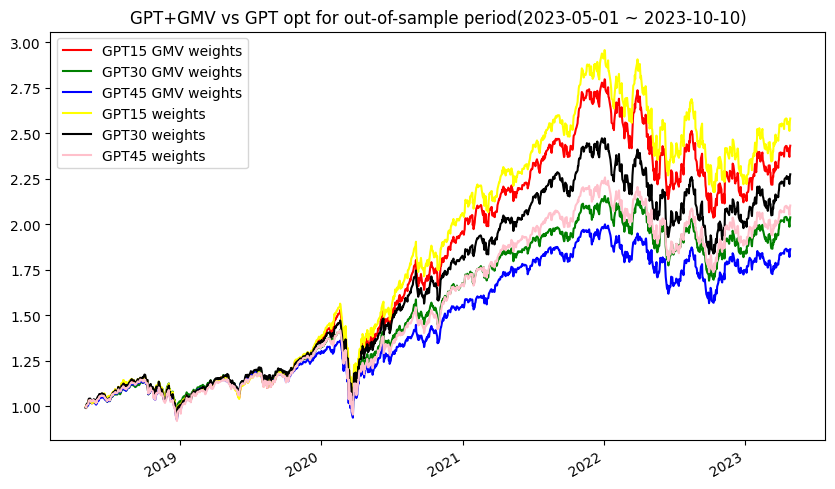

In [34]:
# Log

plt.figure(figsize=(10,6))
plt.title("GPT+GMV vs GPT opt for out-of-sample period(2023-05-01 ~ 2023-10-10)")

cum_15.plot(label='GPT15 GMV weights', color='red')
cum_30.plot(label='GPT30 GMV weights', color='green')
cum_45.plot(label='GPT45 GMV weights', color='blue')
gpt_15.plot(label='GPT15 weights', color='yellow')
gpt_30.plot(label='GPT30 weights', color='black')
gpt_45.plot(label='GPT45 weights', color='pink')

plt.legend()
plt.show()

### out-of-sample 누적 수익률 확인 2023-05-01 ~ 2023-10-10

In [27]:
cum_15 = cum_ret_gmv_epo(stocks_15, gmv_epo_15, '2023-05-01', '2023-10-10')
cum_30 = cum_ret_gmv_epo(stocks_30, gmv_epo_30, '2023-05-01', '2023-10-10')
cum_45 = cum_ret_gmv_epo(stocks_45, gmv_epo_45, '2023-05-01', '2023-10-10')

100%|██████████| 45/45 [00:00<00:00, 848.86it/s]


In [30]:
gpt_15 = cum_ret_gpt(stocks_15, '2023-04-29', '2023-10-10')
gpt_30 = cum_ret_gpt(stocks_30, '2023-04-29', '2023-10-10')
gpt_45 = cum_ret_gpt(stocks_45, '2023-04-29', '2023-10-10')

100%|██████████| 15/15 [00:00<00:00, 863.58it/s]


100%|██████████| 45/45 [00:00<00:00, 865.19it/s]


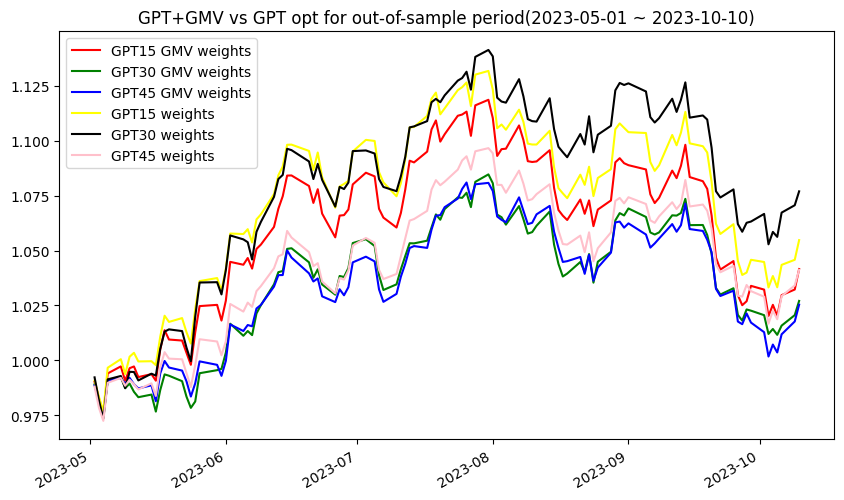

In [31]:
# Log

plt.figure(figsize=(10,6))
plt.title("GPT+GMV vs GPT opt for out-of-sample period(2023-05-01 ~ 2023-10-10)")

cum_15.plot(label='GPT15 GMV weights', color='red')
cum_30.plot(label='GPT30 GMV weights', color='green')
cum_45.plot(label='GPT45 GMV weights', color='blue')
gpt_15.plot(label='GPT15 weights', color='yellow')
gpt_30.plot(label='GPT30 weights', color='black')
gpt_45.plot(label='GPT45 weights', color='pink')

plt.legend()
plt.show()

## Max Sharpe + EPO

In [ ]:
# Max Sharpe 함수 + shrinkage parameter
def max_sharpe_epo(dict):
    df = download(dict, "2018-05-01", "2023-04-30")

    mu = expected_returns.mean_historical_return(df) # pfo mean 
    S = risk_models.sample_cov(df) # cov
    ef = EfficientFrontier(mu, S)

    n_assets = len(mu)  # 자산 수
    min_weights = 0.5 * 1 / n_assets  # 각 자산별 최소 weight
    max_weights = 2 * 1 / n_assets

    for asset in mu.index:
        num = mu.index.get_loc(asset)
        ef.add_constraint(lambda w: w[num] <= max_weights)
        ef.add_constraint(lambda w: w[num] >= min_weights)
    
    ef.add_constraint(lambda w: w.sum() == 1)

    w_opt = ef.max_sharpe_epo() # Max Sharpe ratio가 되는 weights 찾기

    w_clean = ef.clean_weights()
    print()
    ef.portfolio_performance(verbose=True) 
    # print(w_clean) # 가중치 확인
    max_weight_asset = max(w_clean, key=w_clean.get)
    max_weight_value = w_clean[max_weight_asset]

    print()
    print("가장 큰 가중치를 가진 자산:", max_weight_asset)
    print("가장 큰 가중치:", max_weight_value)

    return w_clean